### Time series + EMA

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.  What would the dataframe look like?  Use time series method for detecting anomalies, like exponential moving average with %b. 


To measure anomalies for each cohort in number of page views per day:
2. group by day, cohort_id, aggregate page_viewed using count
3. compute EMA by cohort, 7 days, UB and LB
4. compute %b for each user

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

### Wrangle Data

In [2]:
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('data/anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

In [3]:
df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289480 entries, 0 to 315103
Data columns (total 5 columns):
date           289480 non-null object
page_viewed    289480 non-null object
user_id        289480 non-null int64
cohort_id      289480 non-null int64
ip             289480 non-null object
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None


,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [4]:
colnames=['cohort_name','cohort_id']
df_cohort = pd.read_csv('data/cohort_id_name.csv',
                       names=colnames, 
                       skiprows=1)
print(df_cohort.info())
df_cohort.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
cohort_name    31 non-null object
cohort_id      31 non-null int64
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes
None


,cohort_name,cohort_id
0,Arches,1
1,Badlands,2
2,Carlsbad,3
3,Denali,4
4,Everglades,5


In [5]:
df = df.merge(df_cohort, on='cohort_id', how='left')
df.head()

,date,page_viewed,user_id,cohort_id,ip,cohort_name
0,2018-01-26,/,1,8,97.105.19.61,Hampton
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy


In [6]:
df['date'] = pd.to_datetime(df.date)
df = df.dropna()

In [7]:
df_agg = df.groupby(['date','cohort_id','cohort_name'])['user_id'].\
                        nunique().\
                    reset_index().\
                    rename(index=str, 
                       columns={'user_id': 'users_viewed'})

In [8]:
df_agg.head()

,date,cohort_id,cohort_name,users_viewed
0,2018-01-26,1,Arches,1
1,2018-01-26,8,Hampton,1
2,2018-01-26,13,Kings,1
3,2018-01-26,16,Niagara,2
4,2018-01-26,18,Pinnacles,1


### EMA

In [9]:
cohorts = list(df_agg.cohort_name.unique())
cohorts

['Arches',
 'Hampton',
 'Kings',
 'Niagara',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Teddy',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda']

In [10]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4341 entries, 0 to 4340
Data columns (total 4 columns):
date            4341 non-null datetime64[ns]
cohort_id       4341 non-null int64
cohort_name     4341 non-null object
users_viewed    4341 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 169.6+ KB


In [11]:
df = df_agg.set_index('date').\
            rename(index=str, columns={'users_viewed':'ema'}).\
            drop(columns='cohort_id')


In [12]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    ema["cohort_name"] = df.cohort_name
    return ema.reset_index()

In [13]:
# bollinger_bands(df_agg[df_agg.cohort_id==8])
bands = []
for cohort in cohorts:
    bb = bollinger_bands(df[df.cohort_name == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

In [14]:
df2.head()

,date,ema,stdev,ub,lb,cohort_name
0,2018-01-26 00:00:00,1.000000,NaN,NaN,NaN,Arches
1,2018-01-29 00:00:00,1.266667,NaN,NaN,NaN,Arches
2,2018-01-30 00:00:00,1.364444,NaN,NaN,NaN,Arches
3,2018-01-31 00:00:00,1.449185,NaN,NaN,NaN,Arches
4,2018-02-01 00:00:00,1.389294,NaN,NaN,NaN,Arches


In [15]:
df2.isnull().sum()

date             0
ema              0
stdev          309
ub             309
lb             309
cohort_name      0
dtype: int64

In [16]:
df_missing = df2[df2.stdev.isnull()][['cohort_name','ema']]
df_missing.head()

,cohort_name,ema
0,Arches,1.000000
1,Arches,1.266667
2,Arches,1.364444
3,Arches,1.449185
4,Arches,1.389294


In [17]:
df_missing = df_missing.groupby('cohort_name').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})
df_missing.head()

,cohort_name,stdev_null
0,Andromeda,3.418950
1,Apollo,0.000000
2,Arches,0.212673
3,Badlands,0.000000
4,Denali,0.000000


In [18]:
df = df2.merge(df_missing, on='cohort_name', how='left')

In [19]:
df.head()

,date,ema,stdev,ub,lb,cohort_name,stdev_null
0,2018-01-26 00:00:00,1.000000,NaN,NaN,NaN,Arches,0.212673
1,2018-01-29 00:00:00,1.266667,NaN,NaN,NaN,Arches,0.212673
2,2018-01-30 00:00:00,1.364444,NaN,NaN,NaN,Arches,0.212673
3,2018-01-31 00:00:00,1.449185,NaN,NaN,NaN,Arches,0.212673
4,2018-02-01 00:00:00,1.389294,NaN,NaN,NaN,Arches,0.212673


In [20]:
idx = df.stdev.isnull()
df.loc[idx,'stdev'] = df.loc[idx,'stdev_null']
df = df.drop(columns='stdev_null')
df.head()

,date,ema,stdev,ub,lb,cohort_name
0,2018-01-26 00:00:00,1.000000,0.212673,NaN,NaN,Arches
1,2018-01-29 00:00:00,1.266667,0.212673,NaN,NaN,Arches
2,2018-01-30 00:00:00,1.364444,0.212673,NaN,NaN,Arches
3,2018-01-31 00:00:00,1.449185,0.212673,NaN,NaN,Arches
4,2018-02-01 00:00:00,1.389294,0.212673,NaN,NaN,Arches


In [21]:
idx = df.ub.isnull()
df.loc[idx,'ub'] = df.loc[idx,'ema'] + df.loc[idx,'stdev']*3
df.loc[idx,'lb'] = df.loc[idx,'ema'] - df.loc[idx,'stdev']*3
df.head()

,date,ema,stdev,ub,lb,cohort_name
0,2018-01-26 00:00:00,1.000000,0.212673,1.638018,0.361982,Arches
1,2018-01-29 00:00:00,1.266667,0.212673,1.904685,0.628648,Arches
2,2018-01-30 00:00:00,1.364444,0.212673,2.002463,0.726426,Arches
3,2018-01-31 00:00:00,1.449185,0.212673,2.087204,0.811167,Arches
4,2018-02-01 00:00:00,1.389294,0.212673,2.027312,0.751275,Arches


In [22]:
idx = df.ub == df.lb
df.loc[idx,'ub'] = df.loc[idx,'ub'] + .01
df.loc[idx,'lb'] = df.loc[idx,'lb'] - .01

In [23]:
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 0 to 4340
Data columns (total 6 columns):
date           4341 non-null datetime64[ns]
ema            4341 non-null float64
stdev          4341 non-null float64
ub             4341 non-null float64
lb             4341 non-null float64
cohort_name    4341 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 237.4+ KB


In [24]:
df_agg.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4341 entries, 0 to 4340
Data columns (total 4 columns):
date            4341 non-null datetime64[ns]
cohort_id       4341 non-null int64
cohort_name     4341 non-null object
users_viewed    4341 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 169.6+ KB


In [25]:
# join with aggregated dataset to get the original count of users viewed
df = df.merge(df_agg, on=['cohort_name','date'], how='left')

In [26]:
df.head()

,date,ema,stdev,ub,lb,cohort_name,cohort_id,users_viewed
0,2018-01-26,1.000000,0.212673,1.638018,0.361982,Arches,1,1
1,2018-01-29,1.266667,0.212673,1.904685,0.628648,Arches,1,3
2,2018-01-30,1.364444,0.212673,2.002463,0.726426,Arches,1,2
3,2018-01-31,1.449185,0.212673,2.087204,0.811167,Arches,1,2
4,2018-02-01,1.389294,0.212673,2.027312,0.751275,Arches,1,1


In [27]:
# compute %b
df['pct_b'] = (df.users_viewed-df.lb)/(df.ub-df.lb)
df = df.drop(columns=['stdev','cohort_id'])
df.head()

,date,ema,ub,lb,cohort_name,users_viewed,pct_b
0,2018-01-26,1.000000,1.638018,0.361982,Arches,1,0.500000
1,2018-01-29,1.266667,1.904685,0.628648,Arches,3,1.858372
2,2018-01-30,1.364444,2.002463,0.726426,Arches,2,0.998070
3,2018-01-31,1.449185,2.087204,0.811167,Arches,2,0.931661
4,2018-02-01,1.389294,2.027312,0.751275,Arches,1,0.194920


In [28]:
df[df.pct_b>1].sort_values(by='pct_b', ascending=False)

,date,ema,ub,lb,cohort_name,users_viewed,pct_b
2597,2018-11-05,1.909928,2.261775,1.558080,Ulysses,5,4.891207
958,2018-07-11,1.140681,1.241638,1.039724,Quincy,2,4.755855
1935,2018-11-07,1.138224,1.239632,1.036816,Lassen,2,4.749037
1866,2018-08-20,1.137121,1.239248,1.034993,Lassen,2,4.724532
601,2018-11-19,1.284884,1.488118,1.081650,Kings,3,4.719563
2265,2019-02-22,1.135978,1.239178,1.032778,Olympic,2,4.686151
2054,2019-06-05,1.135792,1.239198,1.032386,Lassen,2,4.678720
2326,2019-05-20,1.135680,1.239214,1.032147,Olympic,2,4.674113
1841,2018-07-19,1.135526,1.239240,1.031812,Lassen,2,4.667579
744,2018-11-21,1.135452,1.239256,1.031648,Niagara,2,4.664343


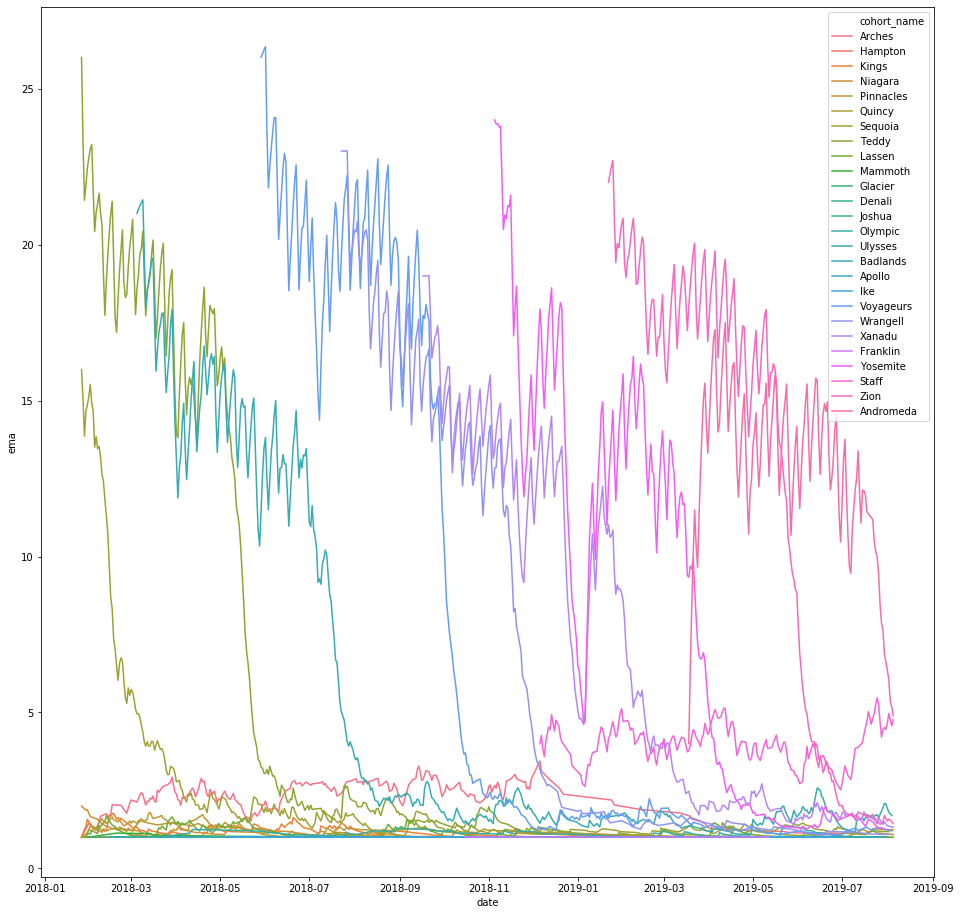

In [29]:
# plot the 7 day exponential moving average
fig = plt.figure(figsize=(16,16))
sns.lineplot(df.date, df.ema, hue=df.cohort_name)